# Movie Recommendation Using NLP

### Import necessary libraries

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import io
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from skimage import io
from IPython.display import clear_output

## Data Preprocessing

In [3]:
# read the dataset https://www.kaggle.com/datasets/akshaypawar7/millions-of-movies
df = pd.read_csv('movies.csv')

In [4]:
# drop movies that have a short description
df['word_count'] = df['overview'].apply(lambda x: len(str(x).split()))
df = df[df['word_count'] >= 50]
df.drop('word_count', axis=1, inplace=True)

In [5]:
#drop movies with low vote_count
df.drop(df[df.vote_count < 100].index, inplace=True)

In [6]:
# drop all duplicates
df.drop_duplicates(subset=['title', 'release_date'], inplace=True)
df.reset_index(drop=True, inplace=True)

In [7]:
# Drop rows with missing poster_path
df.dropna(subset=['poster_path'], inplace=True)

In [8]:
# fill empty cells
df.fillna(value={i: '' for i in ['overview', 'genres', 'keywords', 'credits']}, inplace=True)

In [9]:
# lambda function to preprocess string data
strOp= lambda x: ' '.join(x.split('-'))

In [10]:
# add keywords, genres and credits to overview for full information
df.overview = df.overview + df.keywords.apply(strOp) + df.genres.apply(strOp) + df.credits.apply(lambda x: ' '.join(x.replace(' ', '').split('-')[:3]))
# example
# df.overview[0]

### Initialize the TF-IDF Vectorizer to transform text data into vectors

#### only run these lines once!

In [11]:
# TF-IDF Vectorizer to transform words into numbers and remove common english words like 'the'
tfidf = TfidfVectorizer(stop_words='english')

In [12]:
# transform overview data with TF-IDF vectorizer to create matrix
tfidf_matrix = tfidf.fit_transform(df['overview'])

In [13]:
#display some columns with vectorized words
display(pd.DataFrame(
    tfidf_matrix[:5, 10000:10005].toarray(),
    columns= tfidf.get_feature_names_out()[10000:10005],
    index = df.title[:5]).round())

print(tfidf_matrix.shape)
# over 970000 different words used to describe all movies

,couragemystery,courageous,courageously,courier,courneuve
title,,,,,
Avatar: The Way of Water,0.0,0.0,0.0,0.0,0.0
Ant-Man and the Wasp: Quantumania,0.0,0.0,0.0,0.0,0.0
Creed III,0.0,0.0,0.0,0.0,0.0
Knock at the Cabin,0.0,0.0,0.0,0.0,0.0
Black Panther: Wakanda Forever,0.0,0.0,0.0,0.0,0.0


(6670, 48252)


## Movie Recommendation

### Initialize the recommendation function

In [14]:
def get_recommendation(user_input):
    # Vectorize user input
    vectorized_input = tfidf.transform([user_input])

    # Calculate cosine similarity between user input and movie overviews
    similarity_scores = cosine_similarity(vectorized_input, tfidf_matrix)

    # Get the indices of top similar movies
    top_indices = similarity_scores.argsort()[0][::-1][:50]

    # Retrieve the top recommended movies
    recommended_movies = df.iloc[top_indices]

    # Sort movies based on vote_average and get the top 3 highest rated movies
    top_rated_movies = recommended_movies.sort_values(by='vote_average', ascending=False).iloc[:3]

    # Sort movies based on popularity and get the top 3 most popular movies
    most_popular_movies = recommended_movies.sort_values(by='popularity', ascending=False).iloc[:3]

    # Display movie posters for the recommended movies
    fig, ax = plt.subplots(3, 3, figsize=(20, 20))
    ax = ax.flatten()
    for i, j in enumerate(recommended_movies.poster_path):
        try:
            ax[i].axis('off')
            ax[i].set_title(recommended_movies.iloc[i].title, fontsize=22)
            a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
            ax[i].imshow(a)
        except:
            pass

    # Display highest rated movies
    for i, j in enumerate(top_rated_movies.poster_path, start=3):
        try:
            ax[i].axis('off')
            ax[i].set_title(top_rated_movies.iloc[i-3].title, fontsize=22)
            a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
            ax[i].imshow(a)
        except:
            pass

    # Display most popular movies
    for i, j in enumerate(most_popular_movies.poster_path, start=6):
        try:
            ax[i].axis('off')
            ax[i].set_title(most_popular_movies.iloc[i-6].title, fontsize=22)
            a = io.imread(f'https://image.tmdb.org/t/p/w500/{j}')
            ax[i].imshow(a)
        except:
            pass

    fig.tight_layout()
    plt.show()
    print()
    print("Recommended Movies:")
    print(recommended_movies[['title', 'overview']].head(3))
    print()
    print("Highest Rated Movies:")
    print(top_rated_movies[['title', 'overview']].head(3))
    print()
    print("Most Popular Movies:")
    print(most_popular_movies[['title', 'overview']].head(3))

### Ask for User Input

In [17]:
# replace the string with a description of the type of movie you'd like to see
user_input = "apocalypse movie with lots of explosions"

### Show Recommendations

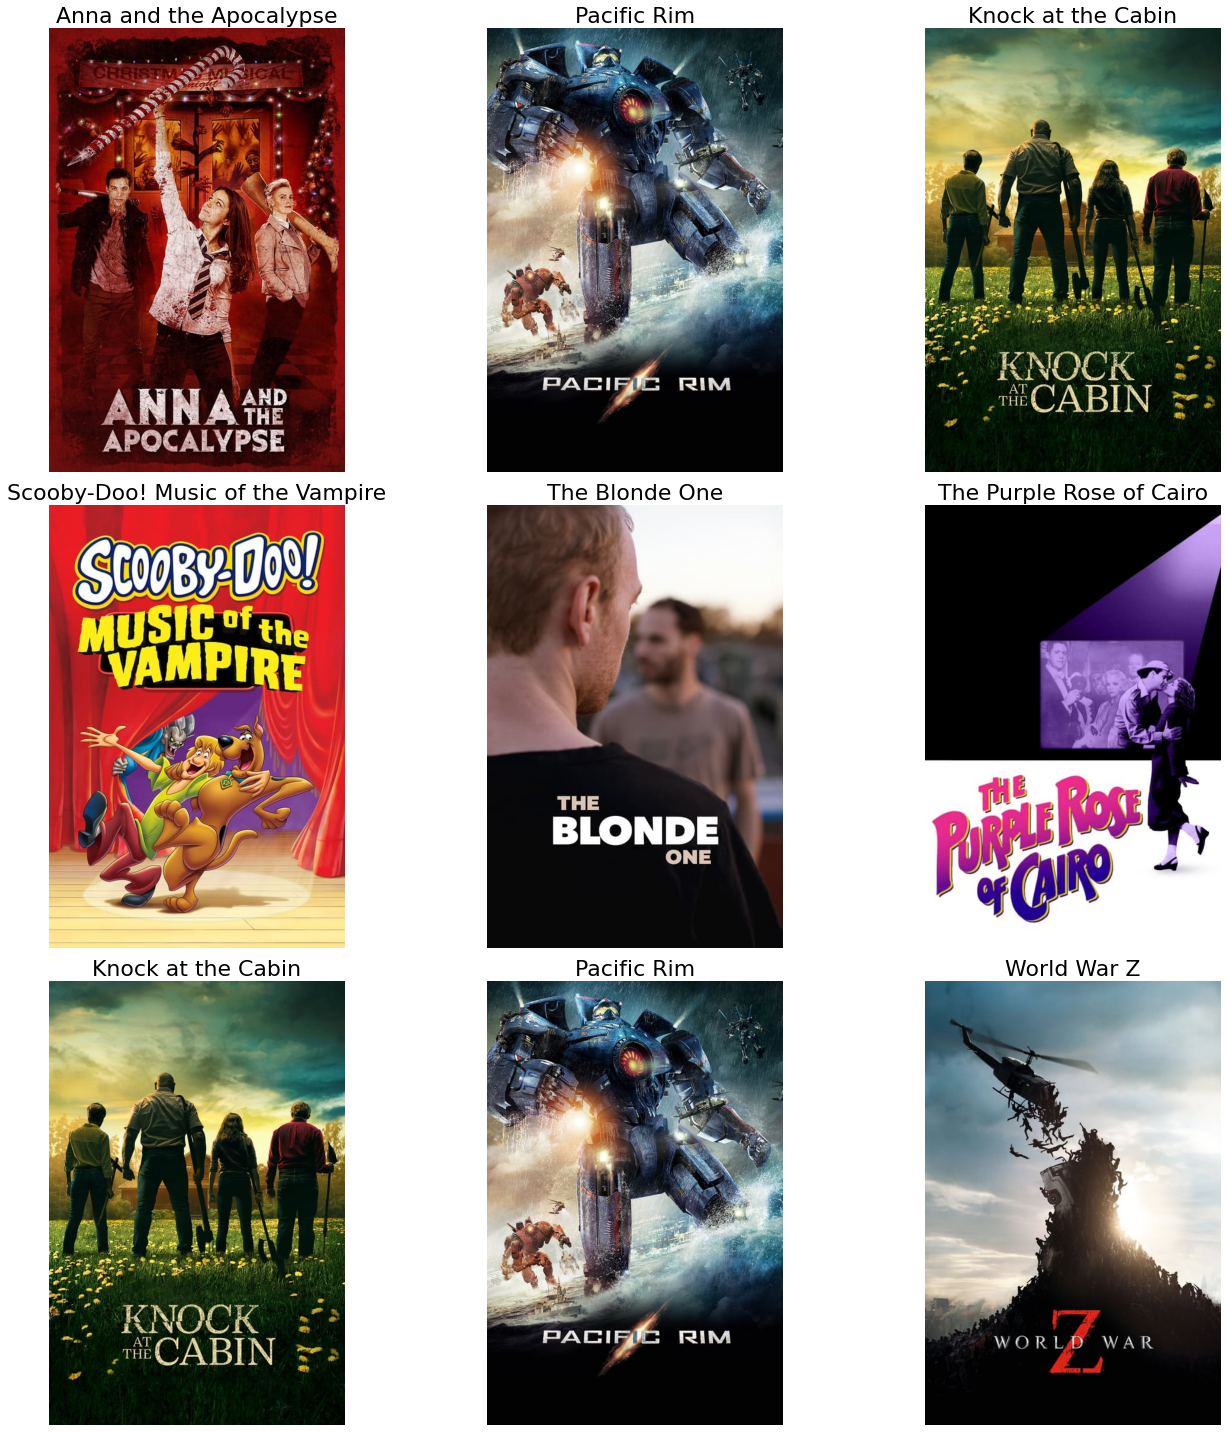


Recommended Movies:
                        title  \
3824  Anna and the Apocalypse   
134               Pacific Rim   
3          Knock at the Cabin   

                                               overview  
3824  A zombie apocalypse threatens the sleepy town ...  
134   Using massive piloted robots to combat the ali...  
3     While vacationing at a remote cabin a young gi...  

Highest Rated Movies:
                                 title  \
2280  Scooby-Doo! Music of the Vampire   
3988                    The Blonde One   
4219          The Purple Rose of Cairo   

                                               overview  
2280  Scooby and the gang have their first musical m...  
3988  Gabriel rents a room in Juan’s House. They wor...  
4219  Cecilia is a waitress in New Jersey living a d...  

Most Popular Movies:
                  title                                           overview
3    Knock at the Cabin  While vacationing at a remote cabin a young gi...
134         Pacifi

In [18]:
get_recommendation(user_input)